# Getting Started with MetaQuantus

This notebook gives the instructions for how to get started with MetaQuantus, with methods explained in the paper:

[**The Meta-Evaluation Problem in Explainable AI:
Rethinking Performance Estimation with MetaQuantus**](INSERT_PREPRINT_LINK)

If you want to reproduce the experiments in the paper, please see the separate notebook **Reproduce-Experiments.ipynb**.

We will use the cMNIST dataset and Make sure to have GPU enabled for performance gains.

In [1]:
!pip install matplotlib==3.5.1
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install captum>=0.4.1
!pip install quantus>=0.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
# Import libraries.
from IPython.display import clear_output
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum 
import quantus
warnings.filterwarnings("ignore", category=UserWarning)
clear_output()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(0))
!nvidia-smi

Using device: Tesla T4
Wed Jan 25 16:11:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

Customise local paths

In [3]:
# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
PATH_DATA = PATH_ASSETS + "data/"

# FIXME: Replace with pip install.
#!pip install metaquantus
# Import local packages.
import sys
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Mounted at /content/drive


## 1) Preliminaries

In [4]:
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

### 1.1 Load data

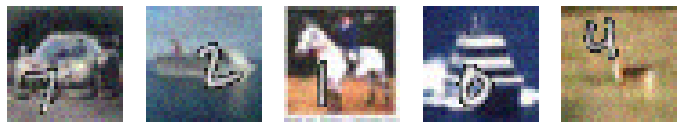

In [5]:
# Load data.
dataset_name = "cMNIST"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

model = dataset_settings[dataset_name]["models"]["ResNet9"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(32,32, 3))
    ax[i].axis("off")
plt.show()

### 1.2 Load explanations

In [6]:
# Load explanations.
xai_setting = ["LayerGradCam", "Saliency"]
xai_methods = setup_xai_settings(
    xai_settings=xai_setting,
    gc_layer=dataset_settings[dataset_name]["gc_layers"][model_name],
    img_size=dataset_kwargs["img_size"],
    nr_channels=dataset_kwargs["nr_channels"],
)

# Generate explanations.
explanations = {}
for method, kwargs in xai_methods.items():
    model = dataset_settings[dataset_name]["models"]["ResNet9"].eval().cpu()
    explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})

xai_methods

{'LayerGradCam': {'gc_layer': 'list(model.named_modules())[1][1][-6]',
  'interpolate': (32, 32),
  'interpolate_mode': 'bilinear'},
 'Saliency': {}}

### 1.3 Load estimators

In [7]:
# Alt 1. Load initalised Quantus estimators, as provided in MetaQuantus.
estimators = setup_estimators(
    features=dataset_kwargs["features"],
    num_classes=dataset_kwargs["num_classes"],
    img_size=dataset_kwargs["img_size"],
    percentage=dataset_kwargs["percentage"],
    patch_size=dataset_kwargs["patch_size"],
    perturb_baseline=dataset_kwargs["perturb_baseline"],
)
estimators

An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.
An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.


{'Robustness': {'Max-Sensitivity': (<quantus.metrics.robustness.max_sensitivity.MaxSensitivity at 0x7f7811734100>,
   True),
  'Local Lipschitz Estimate': (<quantus.metrics.robustness.local_lipschitz_estimate.LocalLipschitzEstimate at 0x7f7811734130>,
   True)},
 'Randomisation': {'Random Logit': (<quantus.metrics.randomisation.random_logit.RandomLogit at 0x7f7811734670>,
   True),
  'Model Parameter Randomisation Test': (<quantus.metrics.randomisation.model_parameter_randomisation.ModelParameterRandomisation at 0x7f7811734490>,
   True)},
 'Faithfulness': {'Faithfulness Correlation': (<quantus.metrics.faithfulness.faithfulness_correlation.FaithfulnessCorrelation at 0x7f7811734520>,
   False),
  'Pixel-Flipping': (<quantus.metrics.faithfulness.pixel_flipping.PixelFlipping at 0x7f7811734760>,
   False)},
 'Complexity': {'Sparseness': (<quantus.metrics.complexity.sparseness.Sparseness at 0x7f78117343a0>,
   False),
  'Complexity': (<quantus.metrics.complexity.complexity.Complexity at 0x7

In [8]:
# Let's pick 'Pointing-Game' (Localisation metric) and its associated boolean, indicating if lower values are interpreted as better.
estimators['Localisation']['Pointing-Game']

(<quantus.metrics.localisation.pointing_game.PointingGame at 0x7f781172ba60>,
 False)

In [9]:
# Alt 2. Define a set of estimators using Quantus, a broader set of Localisation metrics.

estimators_localisation = {
    "Localisation": {
            "Pointing-Game": (
                quantus.PointingGame(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                False,
            ),
             "Top-K Intersection": (quantus.TopKIntersection(
                k=10,
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), False),
             "Relevance Rank Accuracy": (quantus.RelevanceRankAccuracy(
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), False),
            "Relevance Mass Accuracy": (
                quantus.RelevanceMassAccuracy(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                False,
            ),
        }
    }

## 2) Run Meta-Evaluation

In [14]:
from metaquantus import ModelPerturbationTest, InputPerturbationTest
from metaquantus import MetaEvaluation, MetaEvaluationBenchmarking

### 2.1 Define test suite

We define the Input Perturbation Test and Model Perturbation Test in order to evaluate the estimators.

In [11]:
# Define test suite.
test_suite = {
        "Model Resilience Test": ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 0.001,
                "type": "Resilience",
            }
        ),
        "Model Adversary Test": ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 2.0,
                "type": "Adversary",
            }
        ),
        "Input Resilience Test": InputPerturbationTest(
            **{
                "noise": 0.001,
                "type": "Resilience",
            }
        ),
        "Input Adversary Test": InputPerturbationTest(
            **{
                "noise": 5.0,
                "type": "Adversary",
            }
        ),
    }

### 2.2 Run MetaQuantus

Run the meta-evalaution tests on the Sparseness metric (Chalasani et al., 2020) which uses the Gini Index for measuring explaantion quality.

In [12]:
########################
# Master run settings. #
########################

# Define metric.
estimator_category = "Complexity"
estimator_name = "Sparseness"

# Set configs.
iters = 5
K = 10

# Define the meta-evaluation exercise.
meta_evaluator = MetaEvaluation(
    test_suite=test_suite,
    xai_methods=xai_methods,
    iterations=iters,
    nr_perturbations=K,
    write_to_file=False,
)

# Run the meta-evaluation.
meta_evaluator(
    estimator=estimators[estimator_category][estimator_name][0],
    model=dataset_settings[dataset_name]["models"][model_name],
    x_batch=dataset_settings[dataset_name]["x_batch"],
    y_batch=dataset_settings[dataset_name]["y_batch"],
    a_batch=None,
    s_batch=dataset_settings[dataset_name]["s_batch"],
    channel_first=True,
    softmax=False,
    device=device,
    lower_is_better=estimators[estimator_category][estimator_name][1],
)

UID=e64a
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5398 (0.0096)

Model Perturbation Test ---> MC score=0.8121 (0.0211)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.62309069 0.68424799 0.68227099 0.67938459 0.68298437]
		IAC_{AR}: [0.36739308 0.17625982 0.24410417 0.20829687 0.23582649]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.23318604 0.24651154 0.23770889 0.24906843 0.24496814]
	consistency_results:
		IAC_{NR} mean: 0.6703957240015445
		IAC_{NR} std: 0.023706315338531236
		IAC_{AR} mean: 0.24637608656695287
		IAC_{AR} std: 0.023706315338531236
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.24228860775478994
		IEC_{AR} std: 0.00591286086463527
	MC_means: [0.55591745 0.52675484 0.54102101 0.53418747 0.54094475]
	MC_mean: 0.5397651045808218
	MC_std: 0.009635809992405377
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.29457925 0.44310252 0.27206933 0.47660801 0.4299411 ]
		IAC_{AR}: [0.99999981 0.99999943 0.9999914  0.99844842 0.99983189]
		IEC_{NR}: [0.

## 3) Run Benchmarking

In [16]:
# Benchmark localisation metrics, using the intialised meta-evaluator.
benchmark = MetaEvaluationBenchmarking(
    master=meta_evaluator,
    estimators=estimators_localisation,
    experimental_settings=dataset_settings,
    write_to_file=False,
    keep_results=True,
    channel_first=True,
    softmax=False,
    device=device,
)()

cMNIST
  ResNet9
    Localisation
      Pointing-Game
UID=0ea7
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.8854 (0.0028)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.96043935 0.95054918 0.95549427 0.97031999 0.9653749 ]
		IAC_{AR}: [0.99995202 1.         1.         1.         1.        ]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.57554168 0.58149603 0.60287248 0.58014205 0.56497971]
	consistency_results:
		IAC_{NR} mean: 0.9604355379403795
		IAC_{NR} std: 0.006989360661646994
		IAC_{AR} mean: 0.9999904039021175
		IAC_{AR} std: 0.006989360661646994
		IEC_{NR} mean: 1.0
		IEC_{NR} s

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.9377 (0.0028)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.84445634 0.84394731 0.85349762 0.87574093 0.84243114]
		IAC_{AR}: [1. 1. 1. 1. 1.]
		IEC_{NR}: [0.99101562 0.98554688 0.98905484 0.98827819 0.98867034]
		IEC_{AR}: [0.9095616  0.90617938 0.90659944 0.90540381 0.92280707]
	consistency_results:
		IAC_{NR} mean: 0.852014667767038
		IAC_{NR} std: 0.012483505204084365
		IAC_{AR} mean: 1.0
		IAC_{AR} std: 0.012483505204084365
		IEC_{NR} mean: 0.9885131740196078
		IEC_{NR} st

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.8135 (0.0063)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.3468282  0.34317179 0.3212325  0.28564409 0.2901937 ]
		IAC_{AR}: [1. 1. 1. 1. 1.]
		IEC_{NR}: [0.99022672 0.9875     0.98671569 0.98554688 0.98944547]
		IEC_{AR}: [0.95136994 0.94969494 0.93157966 0.95845303 0.9519249 ]
	consistency_results:
		IAC_{NR} mean: 0.3174140566462313
		IAC_{NR} std: 0.025665198864248596
		IAC_{AR} mean: 1.0
		IAC_{AR} std: 0.025665198864248596
		IEC_{NR} mean: 0.9878869485294117
		IEC_{NR} s

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5164 (0.0071)

Model Perturbation Test ---> MC score=0.8127 (0.0234)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.73562041 0.6869971  0.71130661 0.74493246 0.72623458]
		IAC_{AR}: [0.25128029 0.23099765 0.26672721 0.24560039 0.26705515]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.09531563 0.09299995 0.08658551 0.093239   0.0932305 ]
	consistency_results:
		IAC_{NR} mean: 0.7210182314946094
		IAC_{NR} std: 0.020317860069147098
		IAC_{AR} mean: 0.25233213638034163
		IAC_{AR} std: 0.020317860069147098
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.09227411851805319
		IEC_{AR} std: 0.00296592561780012
	MC_means: [0.52055408 0.50274867 0.51615483 0.52094296 0.52163006]
	MC_mean: 0.5164061215982512
	MC_std: 0.0070946047861435504
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.42103816 0.28744711 0.40585174 0.42323119 0.18028294]
		IAC_{AR}: [1. 1. 1. 1. 1.]
		IEC_{NR}: [0.99257659 0.99452819 0.99452819 0.992962